# Cost Estimation For IRIDE Constellation


## Imports
In this section there are all the imports necessary for the notebook

In [2]:
import pandas as pd
pd.set_option('expand_frame_repr', False)
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tabulate import tabulate
import matplotlib.colors as mcolors
import matplotlib.cm as cm

## Costs
In this section the function that load the costs is defined.

In [3]:
def load_costs():
    dtype_dict = {
        'Type': str,
        'Recurring Period (year)': int,
        'Date': int,
        'Activity Duration': int,
        'Amortization Duration': int,
        'Firm': str,
        'Description': str,
        'Cost (€ mil)': float,
        'Classification': str,
        'Origin': str,
        'Estimation method': str
    }
    df = pd.read_csv('costs-others2.csv', dtype=dtype_dict, thousands=',', decimal='.')
    # Remove unecessary columns
    df = df.drop(columns=['Firm', 'Description', 'Estimation method', 'Origin'])
    return df

df_costs_oth = load_costs()

print(df_costs_oth)

                      Short Name  Recurring Period (year)  Date  Activity Duration  Amortization Duration  Cost (€ mil)      Classification
0                      Financing                        0  2023                  0                      0       1100.00           Financing
1               Satellite b1 RnD                        0  2023                  1                      8         53.67        Build Assets
2       Satellite b1 Development                        9  2023                  1                      8        272.33        Build Assets
3       Satellite b2 Development                        9  2024                  1                      8        216.00        Build Assets
4   Infrastructure Development 1                        0  2023                  1                      8         25.00        Build Assets
5   Infrastructure Development 2                        0  2023                  1                      8         25.00        Build Assets
6   Infrastructure D

Here, there is a visual check that the imported data is as expected. 

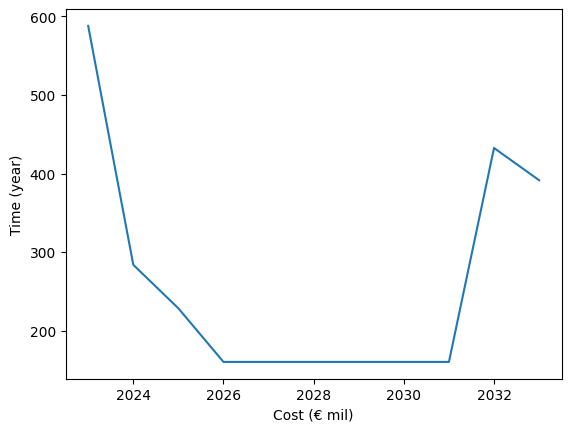

In [4]:
simulation_length = 11 # # of years
time = np.arange(
    np.min(df_costs_oth["Date"]),     # Begin of the simulation
    np.min(df_costs_oth["Date"]) + simulation_length # End of the simulation
    )
costs = np.zeros(simulation_length)
for index, row in df_costs_oth.iterrows():
    if row["Classification"] != "Financing":
        first_pos = row["Date"] - time[0]
        costs[first_pos] += row["Cost (€ mil)"]
        if row["Recurring Period (year)"] > 0:
            first_pos += row["Recurring Period (year)"]
            while first_pos < simulation_length:
                costs[first_pos] += row["Cost (€ mil)"]
                first_pos += row["Recurring Period (year)"]

plt.plot(time, costs)
plt.xlabel('Cost (€ mil)')
plt.ylabel('Time (year)')
plt.show()

## Market Demand Simulator
This section define the market demand function.

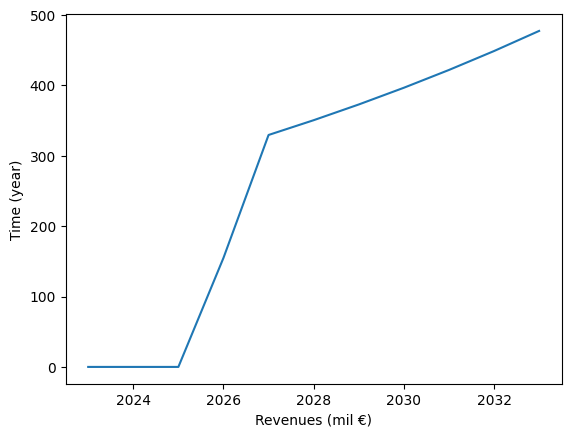

In [5]:
def market_demand_simulator(time:list, first_year_of_revenue:int, max_penetration:float=0):
    market_size_data_2023 = 100
    market_size_data_2033 = 195
    market_size_added_val_2023 = 415
    market_size_added_val_2033 = 760
    market_size_data_CAGR = (market_size_data_2033/market_size_data_2023)**(1/(2033-2023))-1
    market_size_added_val_CAGR = (market_size_added_val_2033/market_size_added_val_2023)**(1/(2033-2023))-1

    market_penetration = np.zeros(simulation_length)
    market_penetration[time == first_year_of_revenue] = 0.5 * max_penetration
    market_penetration[time >  first_year_of_revenue] = max_penetration

    revenues = np.zeros(simulation_length)
    for ii in range(0,simulation_length):
        revenues[ii] = ((market_size_data_2023 * (1 + market_size_data_CAGR) ** ii + 
            market_size_added_val_2023 * (1 + market_size_added_val_CAGR) ** ii) * 
            market_penetration[ii])
    return revenues

revenues = market_demand_simulator(time=time, first_year_of_revenue=2026, max_penetration=0.5)
plt.plot(time, revenues)
plt.xlabel('Revenues (mil €)')
plt.ylabel('Time (year)')
plt.show()

Double check that the income is as expected.

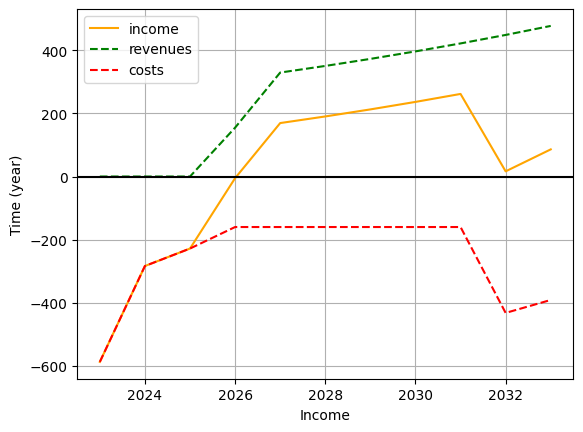

In [6]:
plt.plot(time, revenues - costs, color="orange")
plt.plot(time, revenues, "--", color="green")
plt.plot(time, -costs, "--", color="red")
plt.grid()
plt.xlabel('Income')
plt.ylabel('Time (year)')
plt.legend(["income", "revenues", "costs"])
plt.axhline(y=0, color='k')
plt.show()

## Financial Statements Simulator
In this section the main function of the simulator are defined.

In [7]:
pd.options.display.float_format = '{:,.2f}'.format
class FinancialStatementSimulator():
    def __init__(self, first_year:int=2023, duration:int=11, wacc:float=1):
        self.first_year = first_year
        self.duration = duration
        self.wacc = wacc
        self.years = [first_year + i for i in range(duration)]
        self.delta_balance_sheet = pd.DataFrame(0, index=self.years, columns=[
            'Current Assets',
            'Non-current Assets',
            'Total Assets',
            'Liability',
            'Equity',
            'Total Equity n Liability'
        ]).astype('float64')
        self.balance_sheet = pd.DataFrame(0, index=self.years, columns=[
            'Current Assets',
            'Non-current Assets',
            'Total Assets',
            'Liability',
            'Equity',
            'Total Equity n Liability'
        ]).astype('float64')
        self.income_statement = pd.DataFrame(0, index=self.years, columns=[
            'Revenues',
            'Cost of Revenues',
            'Gross Profit',
            'Operating Expenses',
            'EBITDA',
            'Depreciation & Amortizations',
            'EBIT',
            'Interest Expenses',
            'Tax Expenses',
            'Tax Ratio',
            'Net Income'
        ]).astype('float64')
        self.cash_flow_statement = pd.DataFrame(0, index=self.years, columns=[
            'Operating CF',
            'Investing CF',
            'Financing CF',
            'Net Change in Cash'
        ]).astype('float64')
        
    def _get_year_index(self, year:int):
        if year < self.first_year or year >= self.first_year + self.duration:
            raise ValueError("Year out of bounds.")
        return year
    
    def _update_derivate_numbers(self):
        # Update income statement derived numbers
        self.income_statement['Gross Profit'] = self.income_statement['Revenues'] + self.income_statement['Cost of Revenues']
        self.income_statement['EBITDA'] = self.income_statement['Gross Profit'] + self.income_statement['Operating Expenses']
        self.income_statement['EBIT'] = self.income_statement['EBITDA'] + self.income_statement['Depreciation & Amortizations']
        EBT = self.income_statement['EBIT'] + self.income_statement['Interest Expenses']
        EBT = self.income_statement['EBIT'] + self.income_statement['Interest Expenses']
        self.income_statement['Tax Expenses'] = np.where(
            EBT > 0,  # Condition
            EBT * (-self.income_statement['Tax Ratio']),  # true
            0  # false
        )
        self.income_statement['Net Income'] = np.where(
            EBT > 0,  # Condition
            EBT * (1-self.income_statement['Tax Ratio']),  # true
            EBT  # false
        )
        # Update cash flow statements derived numbers
        self.cash_flow_statement['Operating CF'] = self.income_statement['EBIT'] + self.income_statement['Tax Expenses'] - self.income_statement['Depreciation & Amortizations']
        self.cash_flow_statement['Net Change in Cash'] = self.cash_flow_statement['Operating CF'] + self.cash_flow_statement['Investing CF'] + self.cash_flow_statement['Financing CF']
        # Update balance sheet derived numbers
        self.balance_sheet = self.delta_balance_sheet.cumsum()
        self.balance_sheet['Current Assets'] += self.income_statement['Tax Expenses'].cumsum()
        self.balance_sheet['Equity'] += self.income_statement['Tax Expenses'].cumsum()
        self.balance_sheet['Total Assets'] = self.balance_sheet['Current Assets'] + self.balance_sheet['Non-current Assets']
        self.balance_sheet['Total Equity n Liability'] = self.balance_sheet['Equity'] + self.balance_sheet['Liability']

    def finance(self, year:int, amount:float, debt:bool=False):
        yy = self._get_year_index(year)
        self.cash_flow_statement.at[yy, 'Financing CF'] += amount
        self.delta_balance_sheet.at[yy, 'Current Assets'] += amount
        if debt:
            self.delta_balance_sheet.at[yy, 'Liability'] += amount
        else:
            self.delta_balance_sheet.at[yy, 'Equity'] += amount
        self._update_derivate_numbers()
    
    def build_asset(self, year:int, amount:float, amortization_duration:int, recurring_step:int):
        yy = self._get_year_index(year)
        delta = amount / amortization_duration
        jj = yy
        while jj < self.first_year + self.duration:
            self.delta_balance_sheet.at[jj, 'Current Assets'] -= amount
            self.delta_balance_sheet.at[jj, 'Non-current Assets'] += amount
            self.cash_flow_statement.at[jj, 'Investing CF'] -= amount
            for ii in range(1, amortization_duration + 1):
                if jj + ii >= self.first_year + self.duration:
                    break
                self.delta_balance_sheet.at[jj + ii, 'Equity'] -= delta
                self.delta_balance_sheet.at[jj + ii, 'Non-current Assets'] -= delta
                self.income_statement.at[jj + ii, 'Depreciation & Amortizations'] -= delta
            jj += recurring_step if recurring_step > 0 else self.duration
        self._update_derivate_numbers()

    
    def pay_operating_expenses(self, year:int, amount:float, recurring_step:int):
        yy = self._get_year_index(year)
        while yy < self.first_year + self.duration:
            self.delta_balance_sheet.at[yy, 'Current Assets'] -= amount
            self.delta_balance_sheet.at[yy, 'Equity'] -= amount
            self.income_statement.at[yy, 'Operating Expenses'] -= amount
            yy += recurring_step if recurring_step > 0 else self.duration
        self._update_derivate_numbers()
    
    def get_revenues(self, year:int, amount:float, recurring_step:int):
        yy = self._get_year_index(year)
        while yy < self.first_year + self.duration:
            self.delta_balance_sheet.at[yy, 'Current Assets'] += amount
            self.delta_balance_sheet.at[yy, 'Equity'] += amount
            self.income_statement.at[yy, 'Revenues'] += amount
            yy += recurring_step if recurring_step > 0 else self.duration
        self._update_derivate_numbers()
    
    def set_tax_ratios(self, tax_ratios:float|list):
        if isinstance(tax_ratios, list):
            if len(tax_ratios) != self.duration:
                raise ValueError("The length of the tax_ratios does not match the duration")
        self.income_statement['Tax Ratio'] = tax_ratios
    
    def net_present_value(self):
        net_change_in_cash = self.cash_flow_statement['Operating CF'].values + self.cash_flow_statement['Investing CF'].values
        years = np.arange(0, len(net_change_in_cash))
        discounted_cash = net_change_in_cash / (1 + self.wacc) ** years
        npv = np.sum(discounted_cash)
        return npv
    
    def print_results(self):
        print("Balance Sheet:")
        print(self.balance_sheet.T)
        print("\nIncome Statement:")
        print(self.income_statement.T)
        print("\nCash Flow Statement:")
        print(self.cash_flow_statement.T)

# FIN + TAX
fss = FinancialStatementSimulator(first_year=2023, duration=simulation_length, wacc=0.0767)
fss.set_tax_ratios(.24)
fss.finance(year=2023, amount=1100)

# CAPEX
fss.build_asset(year=2023, amount=263.07, amortization_duration=8, recurring_step=0)
fss.build_asset(year=2023, amount=272.33, amortization_duration=8, recurring_step=9)
fss.build_asset(year=2024, amount=231.30, amortization_duration=8, recurring_step=9)
fss.build_asset(year=2025, amount=015.75, amortization_duration=8, recurring_step=9)

# OPEX
fss.pay_operating_expenses(year=2023, amount=052.47, recurring_step=0)
fss.pay_operating_expenses(year=2024, amount=052.47, recurring_step=0)
fss.pay_operating_expenses(year=2025, amount=052.47, recurring_step=0)
fss.pay_operating_expenses(year=2025, amount=160.15, recurring_step=1)

# REV
for ii in range(0, simulation_length):
    fss.get_revenues(year=time[ii], amount=revenues[ii], recurring_step=0)

# RESULTS
print("NPV = ", fss.net_present_value())
fss.print_results()


NPV =  -474.32810422788236
Balance Sheet:
                             2023   2024   2025   2026   2027   2028   2029   2030   2031     2032     2033
Current Assets             512.13 228.36  -0.01  -5.22 147.06 315.29 500.50 703.77 926.25   880.78   899.30
Non-current Assets         535.40 699.77 619.69 521.88 424.08 326.27 228.46 130.66  32.85   274.30   469.59
Total Assets             1,047.53 928.14 619.68 516.67 571.14 641.56 728.97 834.43 959.10 1,155.07 1,368.89
Liability                    0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00     0.00     0.00
Equity                   1,047.53 928.13 619.68 516.67 571.14 641.56 728.97 834.43 959.10 1,155.07 1,368.89
Total Equity n Liability 1,047.53 928.13 619.68 516.67 571.14 641.56 728.97 834.43 959.10 1,155.07 1,368.89

Income Statement:
                               2023    2024    2025    2026    2027    2028    2029    2030    2031    2032    2033
Revenues                       0.00    0.00    0.00  154.94  329.63

## Scheduler
This section is used just to test how to impose temporal relation between the activities (i.e. costs).
It is a section just for testing.

In [8]:
# Define the project parameters
project_begin = 2023
satellite_lifespan = 8
satellite_launch_delay = 0
simulation_length = 11
tax_rate = .24

activities = load_costs()
activities.set_index("Short Name", inplace=True)

# Calculate the begin times for dependent activities
activities.at["Satellite b2 Development", "Date"] = activities.at["Satellite b1 Development", "Date"] + activities.at["Satellite b1 Development", "Activity Duration"]
activities.at["Satellite b1 Launch", "Date"] = activities.at["Satellite b1 Development", "Date"] + activities.at["Satellite b1 Development", "Activity Duration"] + satellite_launch_delay
activities.at["Satellite b2 Launch", "Date"] = activities.at["Satellite b2 Development", "Date"] + activities.at["Satellite b2 Development", "Activity Duration"] + satellite_launch_delay
activities.at["Operation Infrastructure 1", "Date"] = activities.at["Satellite b1 Launch", "Date"] + activities.at["Satellite b1 Launch", "Activity Duration"]
activities.at["Operation Infrastructure 2", "Date"] = activities.at["Satellite b1 Launch", "Date"] + activities.at["Satellite b1 Launch", "Activity Duration"]
activities.at["Operation Infrastructure 3", "Date"] = activities.at["Satellite b1 Launch", "Date"] + activities.at["Satellite b1 Launch", "Activity Duration"]
activities.at["Operation Infrastructure 4", "Date"] = activities.at["Satellite b1 Launch", "Date"] + activities.at["Satellite b1 Launch", "Activity Duration"]
activities.at["Operation Infrastructure 6", "Date"] = activities.at["Operation Infrastructure 5", "Date"] + activities.at["Operation Infrastructure 5", "Activity Duration"]
activities.at["Operation Infrastructure 7", "Date"] = activities.at["Operation Infrastructure 6", "Date"] + activities.at["Operation Infrastructure 6", "Activity Duration"]

# Initialize the FinancialPeriod
fss = FinancialStatementSimulator(first_year=project_begin, duration=simulation_length, wacc=0.0333)
fss.set_tax_ratios(tax_rate)

# Process each activity in the DataFrame
for name, activity in activities.iterrows():
    if activity["Classification"] == "Financing":
        # pass
        fss.finance(year=activity["Date"], amount=activity["Cost (€ mil)"])
    elif activity["Classification"] == "Build Assets":
        # pass
        fss.build_asset(year=activity["Date"], amount=activity["Cost (€ mil)"], amortization_duration=activity["Amortization Duration"], recurring_step=activity["Recurring Period (year)"])
    elif activity["Classification"] == "Operation Expenses":
        fss.pay_operating_expenses(year=activity["Date"], amount=activity["Cost (€ mil)"], recurring_step=activity["Recurring Period (year)"])

# Simulate the revenues
revenues = market_demand_simulator(time=time, first_year_of_revenue=activities.at["Satellite b2 Launch", "Date"] + activities.at["Satellite b2 Launch", "Activity Duration"], max_penetration=0.5)
for ii in range(simulation_length):
    fss.get_revenues(year=time[ii], amount=revenues[ii], recurring_step=0)

# Print the results
print('Activities:')
print(activities)
print('\n')
fss.print_results()


Activities:
                              Recurring Period (year)  Date  Activity Duration  Amortization Duration  Cost (€ mil)      Classification
Short Name                                                                                                                             
Financing                                           0  2023                  0                      0      1,100.00           Financing
Satellite b1 RnD                                    0  2023                  1                      8         53.67        Build Assets
Satellite b1 Development                            9  2023                  1                      8        272.33        Build Assets
Satellite b2 Development                            9  2024                  1                      8        216.00        Build Assets
Infrastructure Development 1                        0  2023                  1                      8         25.00        Build Assets
Infrastructure Development 2        

# NPV Simulation

In [9]:
# Inport activities
activities = load_costs()
activities.set_index("Short Name", inplace=True)

# Set initial values
project_begin = 2023
# avg_satellite_lifespan = 8.5 # copernicus sentinels 7 estimated 9 reached, therefore 8 +- 1
avg_lunch_delay = 0
simulation_length = 11
tax_rate = .24



# Set the schedule
activities.at["Satellite b2 Development", "Date"] = activities.at["Satellite b1 Development", "Date"] + activities.at["Satellite b1 Development", "Activity Duration"]
activities.at["Satellite b1 Launch", "Date"] = activities.at["Satellite b1 Development", "Date"] + activities.at["Satellite b1 Development", "Activity Duration"] + avg_lunch_delay
activities.at["Satellite b2 Launch", "Date"] = activities.at["Satellite b2 Development", "Date"] + activities.at["Satellite b2 Development", "Activity Duration"] + avg_lunch_delay
activities.at["Operation Infrastructure 1", "Date"] = activities.at["Satellite b1 Launch", "Date"] + activities.at["Satellite b1 Launch", "Activity Duration"]
activities.at["Operation Infrastructure 2", "Date"] = activities.at["Satellite b1 Launch", "Date"] + activities.at["Satellite b1 Launch", "Activity Duration"]
activities.at["Operation Infrastructure 3", "Date"] = activities.at["Satellite b1 Launch", "Date"] + activities.at["Satellite b1 Launch", "Activity Duration"]
activities.at["Operation Infrastructure 4", "Date"] = activities.at["Satellite b1 Launch", "Date"] + activities.at["Satellite b1 Launch", "Activity Duration"]
activities.at["Operation Infrastructure 6", "Date"] = activities.at["Operation Infrastructure 5", "Date"] + activities.at["Operation Infrastructure 5", "Activity Duration"]
activities.at["Operation Infrastructure 7", "Date"] = activities.at["Operation Infrastructure 6", "Date"] + activities.at["Operation Infrastructure 6", "Activity Duration"]

# Define the main simulation function
def npv_simulation(wacc, max_penetration):
    # Initialize the FinancialPeriod
    fss = FinancialStatementSimulator(first_year=project_begin, duration=simulation_length, wacc=wacc)
    fss.set_tax_ratios(tax_rate)
    # Process each activity in the DataFrame
    for name, activity in activities.iterrows():
        if activity["Classification"] == "Financing":
            # pass
            fss.finance(year=activity["Date"], amount=activity["Cost (€ mil)"])
        elif activity["Classification"] == "Build Assets":
            # pass
            fss.build_asset(year=activity["Date"], amount=activity["Cost (€ mil)"], amortization_duration=activity["Amortization Duration"], recurring_step=activity["Recurring Period (year)"])
        elif activity["Classification"] == "Operation Expenses":
            fss.pay_operating_expenses(year=activity["Date"], amount=activity["Cost (€ mil)"], recurring_step=activity["Recurring Period (year)"])
    # Setting revenues
    revenues = market_demand_simulator(time=time, first_year_of_revenue=activities.at["Satellite b2 Launch", "Date"] + activities.at["Satellite b2 Launch", "Activity Duration"], max_penetration=max_penetration)
    # Simulate the revenues
    for ii in range(simulation_length):
        fss.get_revenues(year=time[ii], amount=revenues[ii], recurring_step=0)
    return fss.net_present_value()

# Set the input and output vectors
penetration = np.arange(0, 1.01, 0.01)
npv_wacc_0 = np.zeros_like(penetration)         # 0
npv_wacc_ses = np.zeros_like(penetration)       # 0.0432
npv_wacc_planetlab = np.zeros_like(penetration) # 0.0767
npv_wacc_05 = np.zeros_like(penetration)        # 0.0767

# Run the simulation
for idx, pp in enumerate(penetration):
    npv_wacc_0[idx] = npv_simulation(wacc=0, max_penetration=pp)
    npv_wacc_ses[idx] = npv_simulation(wacc=0.0432, max_penetration=pp)
    npv_wacc_planetlab[idx] = npv_simulation(wacc=0.0767, max_penetration=pp)
    npv_wacc_05[idx] = npv_simulation(wacc=0.0767/2, max_penetration=pp)


Plot the results of the simulation

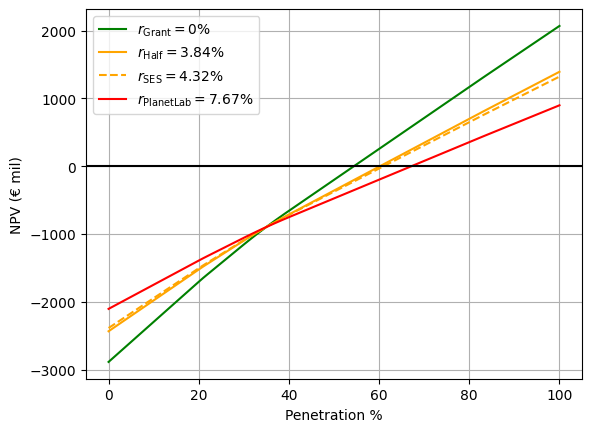

In [10]:
wacc_values = [0, 0.0384, 0.0432, 0.0767]  # WACC values in decimal

# Define colors and line styles
colors = {
    0: 'green',
    0.0384: 'orange',
    0.0432: 'orange',
    0.0767: 'red'
}

linestyles = {
    0: '-',
    0.0384: '-',
    0.0432: '--',
    0.0767: '-'
}

# Plot each line with the corresponding color and style
plt.plot(penetration * 100, npv_wacc_0, color=colors[0], linestyle=linestyles[0], label=r"$r_{\text{Grant}} = 0\%$")
plt.plot(penetration * 100, npv_wacc_05, color=colors[0.0384], linestyle=linestyles[0.0384], label=r"$r_{\text{Half}} = 3.84\%$")
plt.plot(penetration * 100, npv_wacc_ses, color=colors[0.0432], linestyle=linestyles[0.0432], label=r"$r_{\text{SES}} = 4.32\%$")
plt.plot(penetration * 100, npv_wacc_planetlab, color=colors[0.0767], linestyle=linestyles[0.0767], label=r"$r_{\text{PlanetLab}} = 7.67\%$")

# Configure plot
plt.xlabel('Penetration %')
plt.ylabel('NPV (€ mil)')
plt.grid()
plt.legend()
plt.axhline(y=0, color='k')

# Show plot
plt.savefig('plot-NPVs.pdf', format='pdf')
plt.savefig('plot-NPVs.svg', format='svg')
# plt.savefig('plot-NPVs.svg', format='svg')

plt.show()

In this part, I search where the NPV lines cross the y=0 line.

In [11]:
def find_zero_crossings(x, y):
    indices = np.where(np.diff(np.sign(y)))[0]
    zero_crossings = []
    for i in indices:
        x0 = x[i] + (x[i+1] - x[i]) * (0 - y[i]) / (y[i+1] - y[i])
        zero_crossings.append(x0)
    return zero_crossings

crossings_ses = find_zero_crossings(penetration, npv_wacc_ses)
crossings_planetlab = find_zero_crossings(penetration, npv_wacc_planetlab)
crossings_05 = find_zero_crossings(penetration, npv_wacc_05)
crossings_0 = find_zero_crossings(penetration, npv_wacc_0)

print("y=0 crossings_ses: ", crossings_ses[0] if len(crossings_ses) > 0 else "no cross" )
print("y=0 crossings_planetlab: ", crossings_planetlab[0] if len(crossings_planetlab) > 0 else "no cross")
print("y=0 crossings_05: ", crossings_05[0] if len(crossings_05) > 0 else "no cross")
print("y=0 crossings_0: ", crossings_0[0] if len(crossings_0) > 0 else "no cross")

y=0 crossings_ses:  0.6098206438503162
y=0 crossings_planetlab:  0.6715252727869767
y=0 crossings_05:  0.601677785873233
y=0 crossings_0:  0.5439800025708791


## Monte Carlo Simulations
The simulation is run with this parameters:
- 60% market penetration
- wacc = 0


The simulation contains the following fluctuations:

| What | How | Why |
|---|---|---|
|market size | gaussian std 15.5% | VSTOXX |
|delay in the first revenue | discrete variable 75% to 0y delay and 25% to 1y delay | There was an interview that they do not forsee delay, but it is common to have some months delay  in project, half a year is to be conservative. (youtube) |
|satellite lifespan | discrete uniform +-1 y | copernicus sentinels had 7y estimated 9y (and somenthing) reached lifetime (wiki)|

In [12]:
activities = load_costs()
activities.set_index("Short Name", inplace=True)

# Fixed parameters
project_begin = 2023
satellite_launch_delay = 0
simulation_length = 11
tax_rate = .24
wacc = 0
max_penetration = 0.6

# Random variables
delay_revenue_val = [0, 1]
delay_revenue_prb = [.75, .25]
market_pen_std = 0.155
satellite_lifespan_val = [7, 8, 9]
satellite_lifespan_prb = [.33, .34, .33]


# Set the schedule
activities.at["Satellite b2 Development", "Date"] = activities.at["Satellite b1 Development", "Date"] + activities.at["Satellite b1 Development", "Activity Duration"]
activities.at["Satellite b1 Launch", "Date"] = activities.at["Satellite b1 Development", "Date"] + activities.at["Satellite b1 Development", "Activity Duration"] + satellite_launch_delay
activities.at["Satellite b2 Launch", "Date"] = activities.at["Satellite b2 Development", "Date"] + activities.at["Satellite b2 Development", "Activity Duration"] + satellite_launch_delay
activities.at["Operation Infrastructure 1", "Date"] = activities.at["Satellite b1 Launch", "Date"] + activities.at["Satellite b1 Launch", "Activity Duration"]
activities.at["Operation Infrastructure 2", "Date"] = activities.at["Satellite b1 Launch", "Date"] + activities.at["Satellite b1 Launch", "Activity Duration"]
activities.at["Operation Infrastructure 3", "Date"] = activities.at["Satellite b1 Launch", "Date"] + activities.at["Satellite b1 Launch", "Activity Duration"]
activities.at["Operation Infrastructure 4", "Date"] = activities.at["Satellite b1 Launch", "Date"] + activities.at["Satellite b1 Launch", "Activity Duration"]
activities.at["Operation Infrastructure 6", "Date"] = activities.at["Operation Infrastructure 5", "Date"] + activities.at["Operation Infrastructure 5", "Activity Duration"]
activities.at["Operation Infrastructure 7", "Date"] = activities.at["Operation Infrastructure 6", "Date"] + activities.at["Operation Infrastructure 6", "Activity Duration"]

# np.random.normal(loc=cc, scale=0.2 * cc)

# Define the main simulation function
def mc_simulation():
    activities.at["Satellite b1 Development", "Recurring Period (year)"] = np.random.choice(a=satellite_lifespan_val, size=1, p=satellite_lifespan_prb)
    activities.at["Satellite b2 Development", "Recurring Period (year)"] = np.random.choice(a=satellite_lifespan_val, size=1, p=satellite_lifespan_prb)
    activities.at["Satellite b1 Launch", "Recurring Period (year)"] = np.random.choice(a=satellite_lifespan_val, size=1, p=satellite_lifespan_prb)
    activities.at["Satellite b1 Launch", "Recurring Period (year)"] = np.random.choice(a=satellite_lifespan_val, size=1, p=satellite_lifespan_prb)
    # Initialize the FinancialPeriod
    fss = FinancialStatementSimulator(first_year=project_begin, duration=simulation_length, wacc=wacc)
    fss.set_tax_ratios(tax_rate)
    # Process each activity in the DataFrame
    for name, activity in activities.iterrows():
        if activity["Classification"] == "Financing":
            # pass
            fss.finance(year=activity["Date"], amount=activity["Cost (€ mil)"])
        elif activity["Classification"] == "Build Assets":
            # pass
            fss.build_asset(year=activity["Date"], amount=activity["Cost (€ mil)"], amortization_duration=activity["Amortization Duration"], recurring_step=activity["Recurring Period (year)"])
        elif activity["Classification"] == "Operation Expenses":
            fss.pay_operating_expenses(year=activity["Date"], amount=activity["Cost (€ mil)"], recurring_step=activity["Recurring Period (year)"])
    # Setting revenues
    yy = activities.at["Satellite b2 Launch", "Date"] + activities.at["Satellite b2 Launch", "Activity Duration"]
    pp = max_penetration
    revenues = market_demand_simulator(
        time=time, 
        first_year_of_revenue=np.random.choice(a=(delay_revenue_val + yy), size=1, p=delay_revenue_prb), 
        max_penetration=np.random.normal(loc=pp, scale=market_pen_std * pp)) # because both gaussian
    # Simulate the revenues
    for ii in range(simulation_length):
        fss.get_revenues(year=time[ii], amount=revenues[ii], recurring_step=0)
    return fss.net_present_value()

n_samples = 3000
npv_final_distribution_sampling = np.zeros(n_samples)
for idx in range(n_samples):
    npv_final_distribution_sampling[idx] = mc_simulation()
    if idx % (n_samples / 10) == 0:
        print(idx)
    # print(npv_wacc_0[idx])

0
300
600
900
1200
1500
1800
2100
2400
2700


Plot the distribution

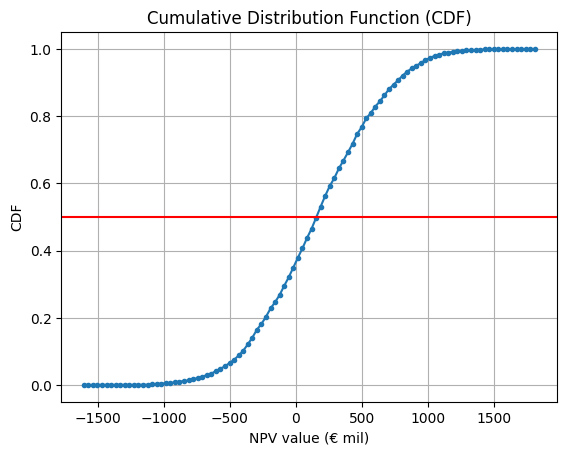

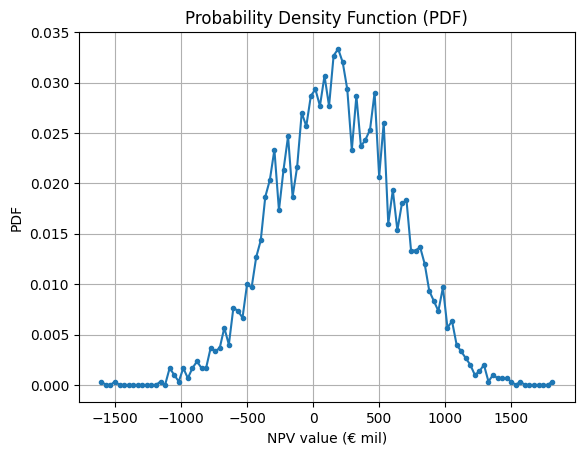

178.51347371298408 450.1167275147437


In [13]:
# n_samples = 100
# npv_final_distribution_sampling = np.random.normal(30, 1, n_samples) 

hist, bin_edges = np.histogram(npv_final_distribution_sampling, bins=100, density=False)
cdf = np.cumsum(hist)
cdf_normalized = cdf / cdf[-1]  # Normalize to range [0, 1]
xx = (bin_edges[:-1] + bin_edges[1:]) / 2

plt.plot(xx, cdf_normalized, marker='.', linestyle='-')
plt.title('Cumulative Distribution Function (CDF)')
plt.xlabel('NPV value (€ mil)')
plt.ylabel('CDF')
plt.grid(True)
plt.axhline(y=0.5, color='r')
plt.savefig('plot-CDF.pdf', format='pdf')
plt.savefig('plot-CDF.svg', format='svg')
plt.show()

plt.plot(xx, hist / sum(hist), marker='.', linestyle='-')
plt.title('Probability Density Function (PDF)')
plt.xlabel('NPV value (€ mil)')
plt.ylabel('PDF')
plt.grid(True)
# plt.axhline(y=0.5, color='r')
plt.savefig('plot-PDF.pdf', format='pdf')
plt.savefig('plot-PDF.svg', format='svg')
plt.show()

print(np.mean(npv_final_distribution_sampling), np.std(npv_final_distribution_sampling))